In [3]:
import random
import matplotlib.pyplot as plt
import pandas as pd
import config
import os
from datetime import datetime
import time


In [9]:
df = pd.read_csv(config.DATA_FILE, parse_dates=['date'])
df['date'] = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%d/%m/%y')
# df = df.groupby(['date', 'lesson'], sort=False)
# df = df.set_index('date')

In [10]:
df.head()

,date,lesson,views,name
0,17/07/20,1-0,8472,Welcome to Udacity
1,17/07/20,1-1,4889,Why Machine Learning?
2,17/07/20,1-2,4460,Course Overview
3,17/07/20,2-0,4575,Lesson Overview
4,17/07/20,2-1,4095,What is Machine Learning?


In [13]:
lessonDf = df[df['lesson'] == '1-0']

In [15]:
lessonDf = lessonDf.set_index('date')

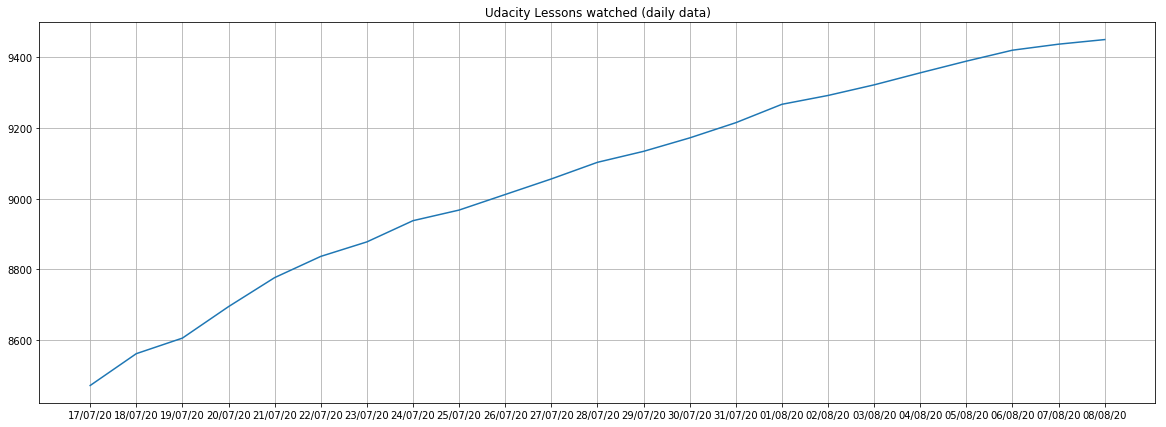

In [16]:
plt.figure(figsize=(20, 7))
plt.plot(lessonDf.views)
plt.title('Udacity Lessons watched (daily data)')
plt.grid(True)
plt.show()